In [43]:
import os
import pandas as pd
import numpy as np
import re
from wordcloud import WordCloud,STOPWORDS
import matplotlib.pyplot as plt
from nltk.corpus import stopwords

In [4]:
reg_expressions={
    'Emojis':r'[\U0001f600-\U0001f650]',
    'hashtags':r"(?:\#+[\w_]+[\w\'_\-]*[\w_]+)",
    'Mentions':r'(?:@[\w_]+)',
    'URLs':r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&amp;+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+',
    'RTs':r"(RT|via)((?:\b\W*@\w+)+)"
}

In [5]:
labels={}
df={}
tag_df={}
for tipo in ['training','test']:
    tweets={}
    labels[tipo]={}
    for doc in os.listdir(tipo):
        if 'xml' in doc:
            with open(tipo+'/'+doc,'r') as xml_doc:
                tweets[doc.strip('.xml')]=' '.join([tweet.replace(']]></document>','') \
                                   for tweet in xml_doc.read().split('<document><![CDATA[')[1:]])\
                .replace('\n\t\t',' || ')
        else:
            with open(tipo+'/'+doc,'r') as txt_doc:
                labels[tipo]=pd.read_csv(txt_doc,sep=':::',header=None,names=['sexo','pais'],engine='python')
    
    
    df[tipo]=pd.DataFrame(list(tweets.values()),index=list(tweets.keys()),columns=['tweets'])
    

    
    tag_df[tipo]={}
    for (key,reg_ex) in reg_expressions.items():
        aux_list=[]
        for index,row in df[tipo].iterrows():
            cuenta=re.findall(reg_ex, row['tweets'])
            cuenta = len(cuenta)
            aux_list.append(cuenta)
        aux_list=np.array(aux_list)
        tag_df[tipo][key]=aux_list
    tag_df[tipo] = pd.DataFrame(tag_df[tipo],index=df[tipo].index)
    labels[tipo]=df[tipo].join(labels[tipo],how='inner')[['sexo','pais']]
    
    max_len=df['training']['tweets'].str.len().max()
    tag_df[tipo]['longitud']=df[tipo]['tweets'].str.len()/max_len
    print(df[tipo].shape,tag_df[tipo].shape,labels[tipo].shape)

(2800, 1) (2800, 6) (2800, 2)
(1400, 1) (1400, 6) (1400, 2)


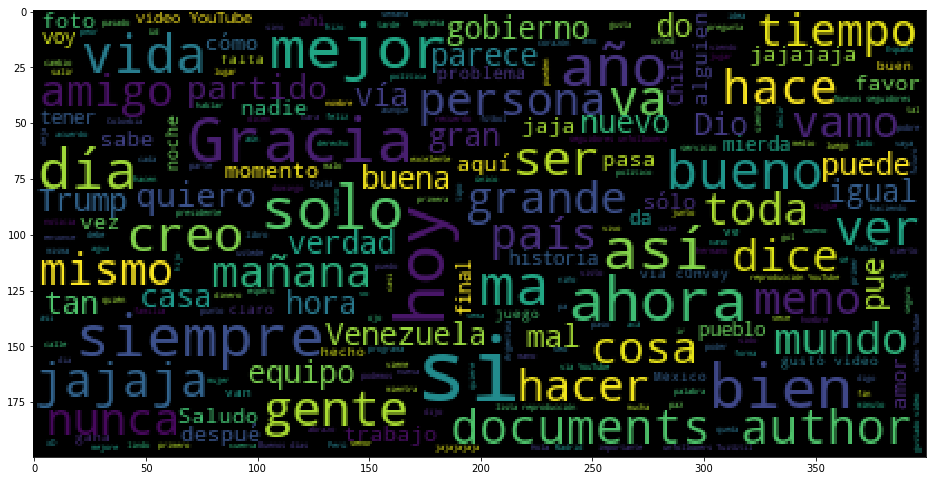

male :
 Emojis      0.024639
hashtags    0.055354
Mentions    0.150901
URLs        0.208577
RTs         0.011186
longitud    0.666084
dtype: float64 



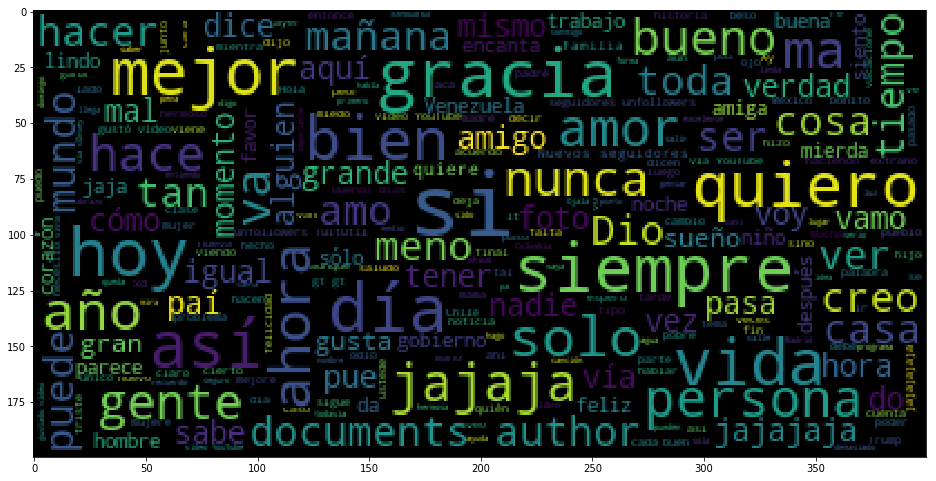

female :
 Emojis      0.055398
hashtags    0.057230
Mentions    0.127426
URLs        0.190549
RTs         0.007836
longitud    0.611633
dtype: float64 



In [45]:
tag_df_sex={}
for sexo in ['male','female']:
    text=df['training'].loc[labels['training']['sexo']==sexo,'tweets'].str.cat()
    plt.figure(figsize=(16,13))
    wc = WordCloud(background_color="black", max_words=10000,\
                   stopwords=stopwords.words('spanish')+['http','https','co'], max_font_size= 40)
    wc.generate(text)
    plt.imshow(wc)
    plt.show()
    tag_df_sex[sexo]=pd.concat([tag_df['training'].loc[labels['training']['sexo']==sexo,:].mean(),\
                                tag_df['test'].loc[labels['test']['sexo']==sexo,:].mean()],axis=1).mean(axis=1) 
    print(sexo,':\n',tag_df_sex[sexo],'\n')

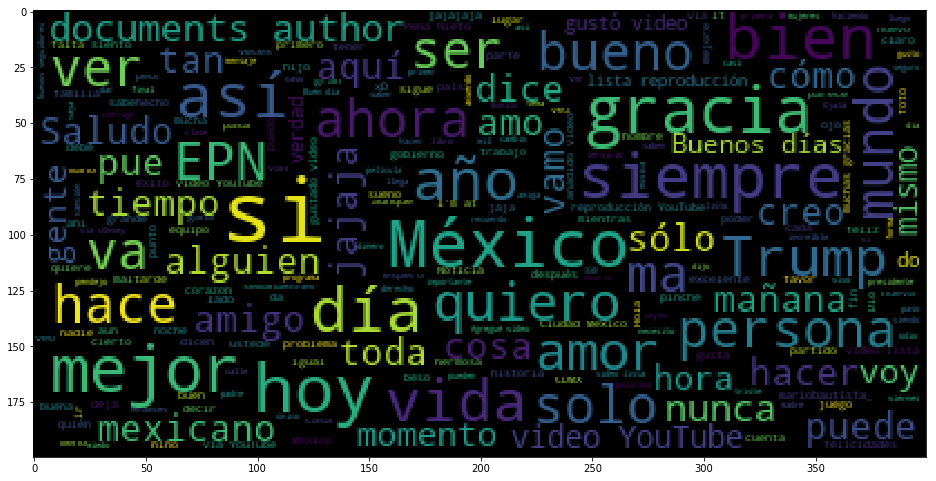

mexico :
 Emojis      0.051534
hashtags    0.074018
Mentions    0.145276
URLs        0.240232
RTs         0.005700
longitud    0.647087
dtype: float64 



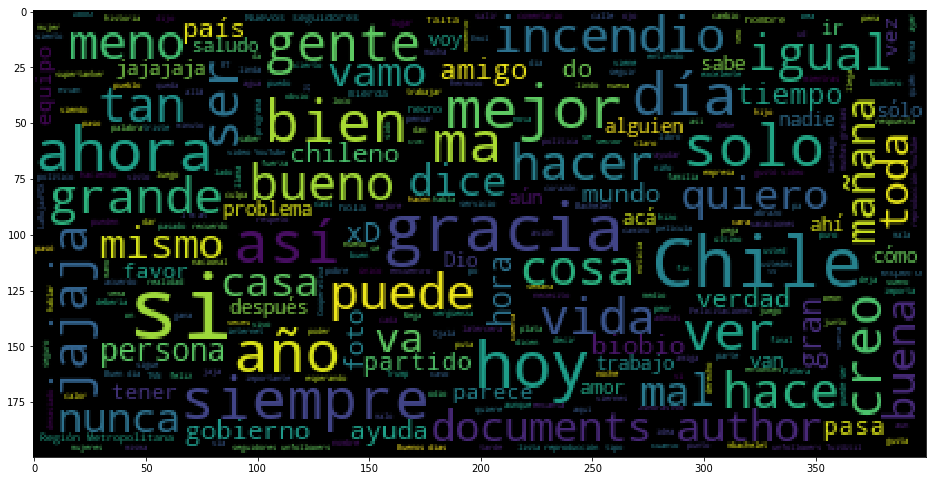

chile :
 Emojis      0.037734
hashtags    0.061177
Mentions    0.149238
URLs        0.177908
RTs         0.007687
longitud    0.641618
dtype: float64 



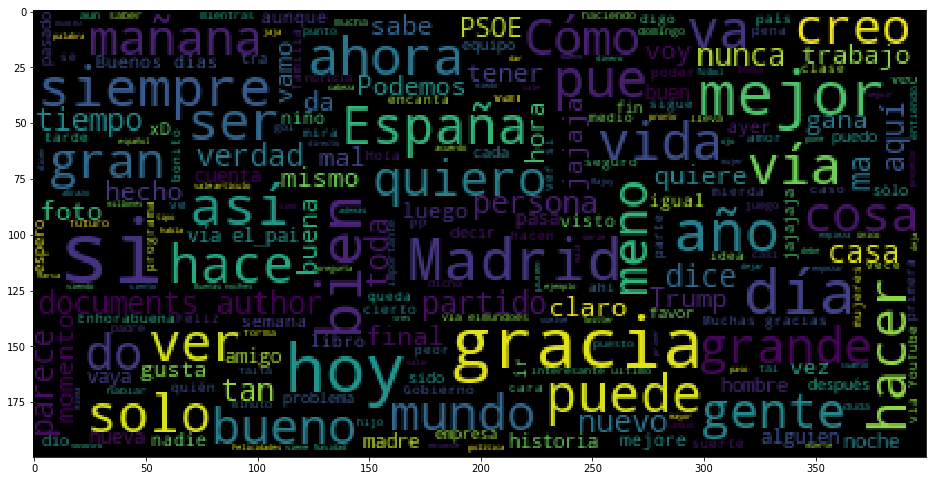

spain :
 Emojis      0.043056
hashtags    0.067121
Mentions    0.162735
URLs        0.240019
RTs         0.007600
longitud    0.674259
dtype: float64 



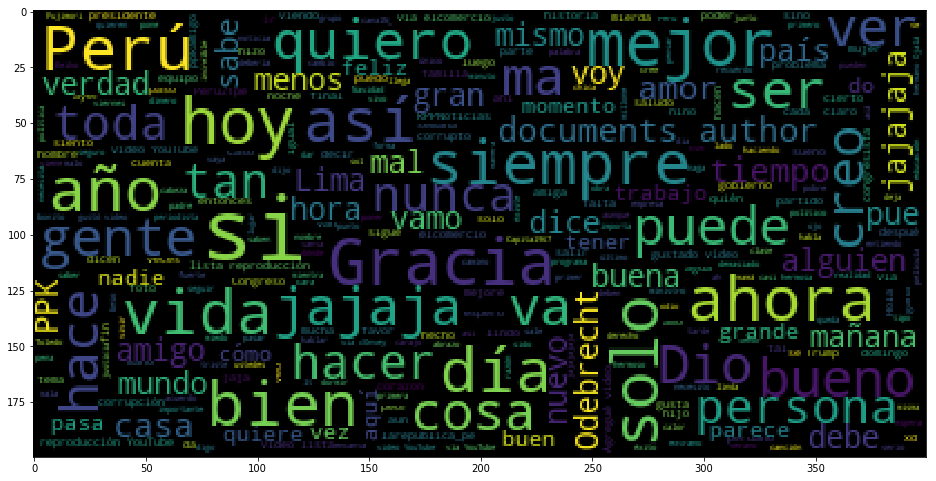

peru :
 Emojis      0.049942
hashtags    0.051366
Mentions    0.134213
URLs        0.194579
RTs         0.004587
longitud    0.632717
dtype: float64 



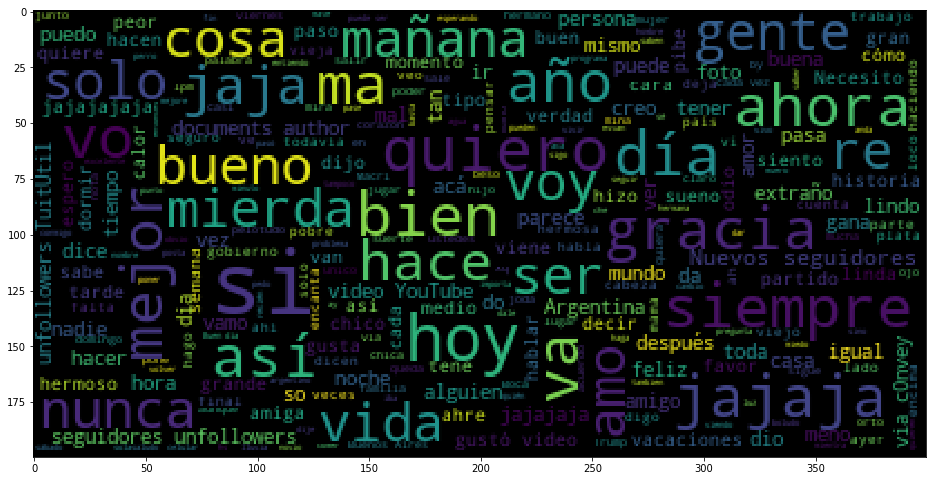

argentina :
 Emojis      0.043587
hashtags    0.036383
Mentions    0.112339
URLs        0.136206
RTs         0.005900
longitud    0.556347
dtype: float64 



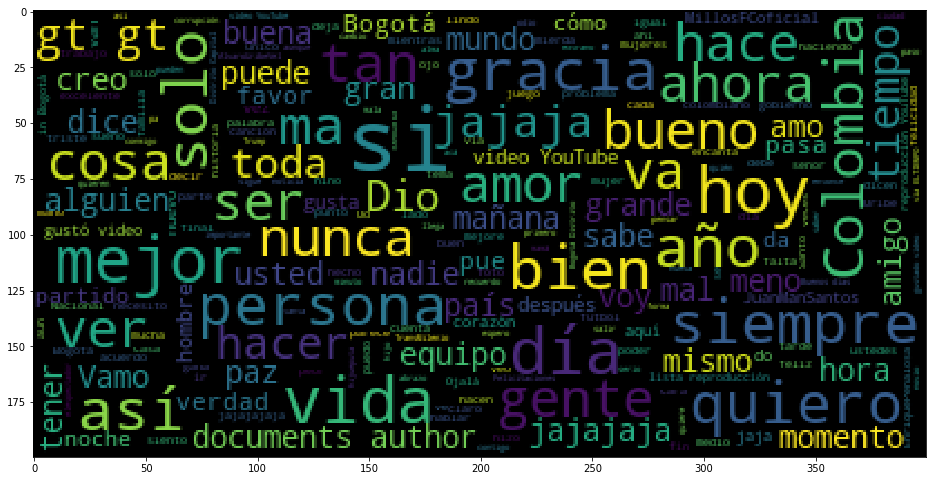

colombia :
 Emojis      0.044706
hashtags    0.044345
Mentions    0.133116
URLs        0.163379
RTs         0.007175
longitud    0.617075
dtype: float64 



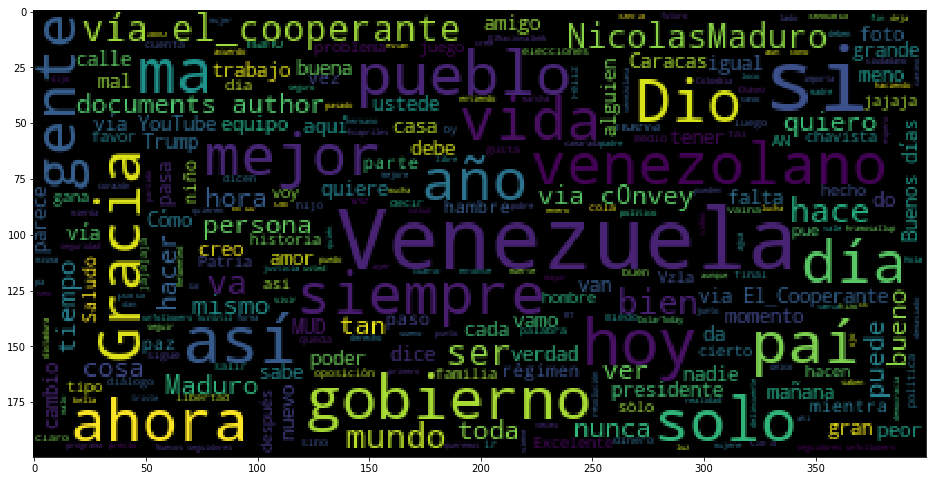

venezuela :
 Emojis      0.009572
hashtags    0.059635
Mentions    0.137224
URLs        0.244617
RTs         0.027925
longitud    0.702906
dtype: float64 



In [46]:
tag_df_pais={}
for pais in labels['training']['pais'].value_counts().index:
    text=df['training'].loc[labels['training']['pais']==pais,'tweets'].str.cat()
    plt.figure(figsize=(16,13))
    wc = WordCloud(background_color="black", max_words=10000,\
                   stopwords=stopwords.words('spanish')+['http','https','co'], max_font_size= 40)
    wc.generate(text)
    plt.imshow(wc)
    plt.show()
    
    tag_df_pais[pais]=pd.concat([tag_df['training'].loc[labels['training']['pais']==pais,:].mean(),\
                                tag_df['test'].loc[labels['test']['pais']==pais,:].mean()],axis=1).mean(axis=1) 
    print(pais,':\n',tag_df_pais[pais],'\n')

In [8]:
tag_df_max=pd.concat([tag_df['training'].max(),tag_df['test'].max()],axis=1).max(axis=1)
tag_df['training']/=tag_df_max
tag_df['test']/=tag_df_max

In [9]:
from sklearn.naive_bayes import MultinomialNB
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier

models=[
    MultinomialNB(),
    LinearSVC(),
    RandomForestClassifier(100,max_depth=25)
]

In [10]:
y_train={}
y_test={}
X_train={}
X_test={}
vectorizers={
    'sexo':TfidfVectorizer(analyzer="word", stop_words=stopwords.words('spanish'),\
                           ngram_range=(1,2), max_df=0.9,max_features=10000),
    'pais':TfidfVectorizer(analyzer="word",\
                           ngram_range=(1,2),max_features=20000)
}

for label in ['sexo','pais']:
    y_train[label]=labels['training'][label].values
    y_test[label]=labels['test'][label].values

    tfidfv=vectorizers[label]

    X_train[label]=tfidfv.fit_transform(df['training']['tweets'].values)
    X_test[label]=tfidfv.transform(df['test']['tweets'].values)

    X_train[label] = np.hstack([X_train[label].toarray(),tag_df['training'].values])
    X_test[label] = np.hstack([X_test[label].toarray(),tag_df['test'].values])
 

In [19]:
predicted={}
for model in models:
    print(str(model.__class__).split('.')[-1].split("'")[0],':')
    for label in ['sexo','pais']:
        model.fit(X_train[label],y_train[label].ravel())
        predicted[label]=(y_test[label].ravel()==model.predict(X_test[label]))
        print('\t',label,': ',predicted[label].mean())
        
    print('\t Joint: ',(predicted['sexo']*predicted['pais']).mean())

MultinomialNB :
	 sexo :  0.6871428571428572
	 pais :  0.7971428571428572
	 Joint:  0.5342857142857143
LinearSVC :
	 sexo :  0.76
	 pais :  0.9342857142857143
	 Joint:  0.7085714285714285
RandomForestClassifier :
	 sexo :  0.7214285714285714
	 pais :  0.9214285714285714
	 Joint:  0.66
